# MRI FOR BRAIN TUMOR

### Importing of Libraries:

In [1]:
import warnings # remove warning messages
warnings.filterwarnings("ignore")

# libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import seaborn as sns

import pandas as pd
import numpy as np
from PIL import Image
import random

# pytorch and dependencies
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from skimage import io, transform

from pathlib import Path
import random

In [2]:
_dir = Path().resolve()
parent_dir = _dir.parent / "datasets/Image Datasets/MRI Brain Tumor Datasets"
train_data_dir = parent_dir / "Train"
test_data_dir = parent_dir / "Val"
model_path = _dir / "models"


# Acquire the Data

Create a custom dataset to be used for loading the data from a directory.

In [3]:
class MRIDataset(Dataset):
    """MRI Dataset."""
    label_to_class = {1: "Meningioma", 0: "Glioma", 2: "No Tumor", 3: "Pituary"}

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_label_dict = self.__image_to_label_map()
    
    def __image_to_label_map(self):
        parent_dir = self.root_dir
        images_dict = {}
        for subdir in parent_dir.iterdir():
            for folder in subdir.iterdir():
                if folder.name == "images":
                    for image in folder.iterdir():
                        images_dict[image.name[:-4]] = [np.asarray(Image.open(image).resize((400,400)))]
                if folder.name == "labels":
                    for label in folder.iterdir():
                        images_dict[label.name[:-4]].append(np.array([float(i) for i in label.read_text().split()[:5]]))
                        if len(images_dict[label.name[:-4]][1]) != 5:
                            images_dict.pop(label.name[:-4])
        new_dict = {}
        i = 0 
        for data_name in images_dict.keys():
            new_dict[i] = images_dict[data_name]
            i += 1
        return new_dict
    
    def __len__(self):
        return len(self.images_label_dict)
    
    def __getitem__(self, index):
        sample = {"image": self.images_label_dict[index][0], "labels": self.images_label_dict[index][1]}
        if self.transform:
            sample = self.transform(sample)
        return sample



## Visualize the Data

Visualize the data to get a feel for what it looks like.

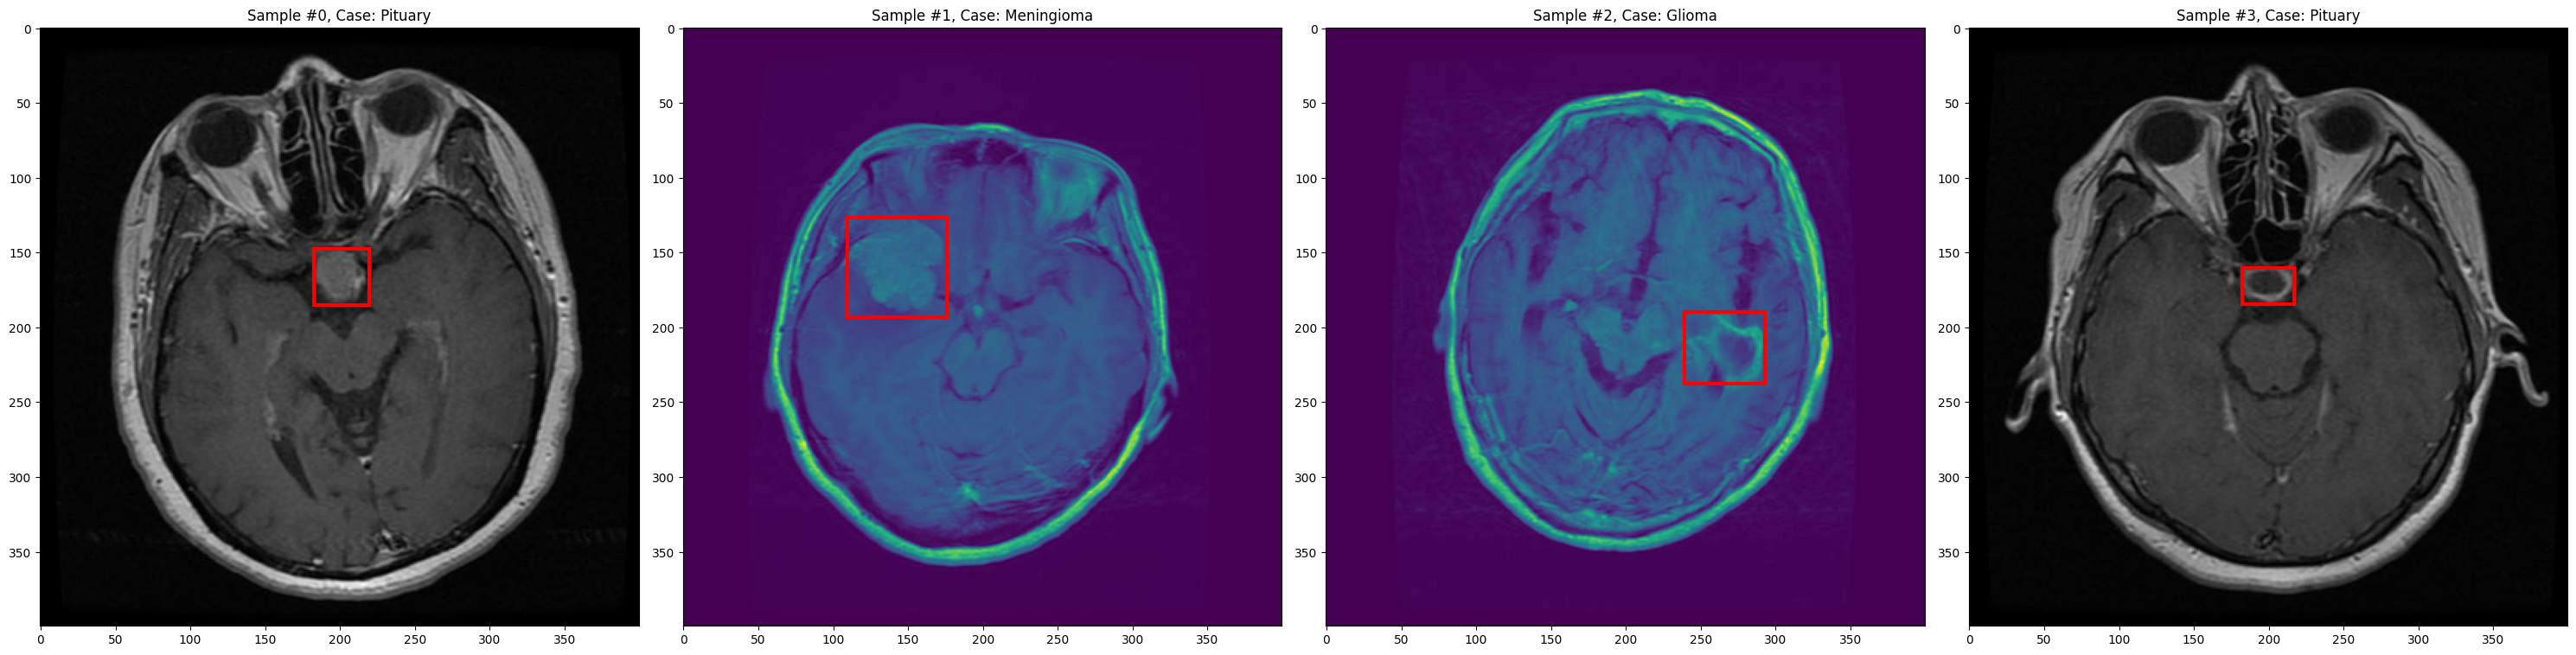

In [4]:
tumor_dataset = MRIDataset(root_dir=parent_dir / "Train")

fig = plt.figure(figsize=(30,14))
random.seed(48)
for i in range(len(tumor_dataset)):
    sample = tumor_dataset[random.randint(1, len(tumor_dataset)-1)]
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    plt.imshow(sample["image"])
    bounding_box = sample["labels"][1:]
    rect = patches.Rectangle(((bounding_box[0]-(bounding_box[2]/2))*400,(bounding_box[1]-(bounding_box[3]/2))*400), bounding_box[2]*400, bounding_box[3]*400, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.set_title('Sample #{}, Case: {}'.format(i, tumor_dataset.label_to_class[float(sample["labels"][0])]))
    ax.axis()

    if i == 3:
        plt.show()
        break

Methods are created to implement transformations on the dataset to ensure data consistency while training the model.

In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        return {'image': img, 'labels': labels}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        if image.ndim ==2:
            image = np.stack([image, image, image], axis=2)
        elif image.ndim == 3 and image.shape[2] == 4:
            image = image[:, :, :3] 
        n_channels = image.shape[2]
        h, w = image.shape[0], image.shape[1]
        image = np.reshape(image, (n_channels,h,w))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}
    

Check if the transformations are working as expected.

tensor([0.0000, 0.4346, 0.3164, 0.1230, 0.1562], dtype=torch.float64)
Glioma


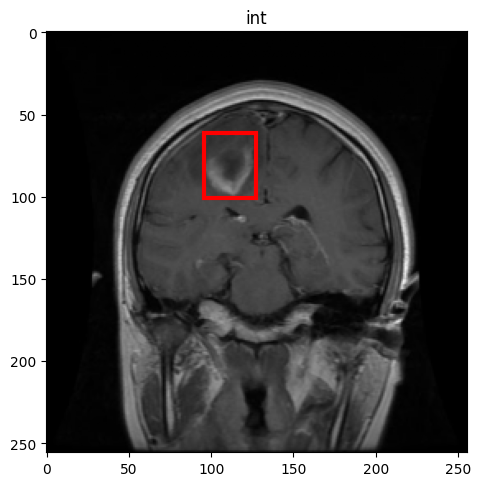

In [6]:
scale = Rescale(256)
tensor_conv = ToTensor()

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = tumor_dataset[1100]

transformed_sample = tensor_conv(scale(sample))
ax = plt.subplot(1, 1,  1)
plt.tight_layout()
ax.set_title(type(i).__name__)
plt.imshow(torch.reshape(transformed_sample["image"],(256,256,3)))
bounding_box = transformed_sample["labels"][1:]
print(transformed_sample["labels"])
print(tumor_dataset.label_to_class[int(transformed_sample["labels"][0])])
rect = patches.Rectangle(((bounding_box[0]-(bounding_box[2]/2))*256,(bounding_box[1]-(bounding_box[3]/2))*256), bounding_box[2]*256, bounding_box[3]*256, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

In [7]:
training_dataset = MRIDataset(train_data_dir, transform=transforms.Compose([Rescale(500),ToTensor()]))
training_dloader = DataLoader( training_dataset,
                              batch_size=64, shuffle=True)
testing_dataset = MRIDataset(test_data_dir, transform=transforms.Compose([Rescale(500),ToTensor()]))
testing_dloader = DataLoader( testing_dataset, 
                              batch_size=64, shuffle=True)

# Training the Neural Network

## Building a Simple Object Localization Model

Model Taken from: https://blog.paperspace.com/object-localization-pytorch-2/

In [8]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # CNNs for rgb images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=5)


        # Connecting CNN outputs with Fully Connected layers for classification
        self.class_fc1 = nn.Linear(in_features=19200, out_features=240)
        self.class_fc2 = nn.Linear(in_features=240, out_features=120)
        self.class_out = nn.Linear(in_features=120, out_features=4)

        # Connecting CNN outputs with Fully Connected layers for bounding box
        self.box_fc1 = nn.Linear(in_features=19200, out_features=240)
        self.box_fc2 = nn.Linear(in_features=240, out_features=120)
        self.box_out = nn.Linear(in_features=120, out_features=4)


    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)
    
        t = torch.flatten(t, start_dim=1)
        

        class_t = self.class_fc1(t)
        class_t = F.relu(class_t)

        class_t = self.class_fc2(class_t)
        class_t = F.relu(class_t)

        class_t = F.softmax(self.class_out(class_t), dim=1)

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        box_t = F.sigmoid(box_t)

        return [class_t,box_t]

In [9]:
model = Network()

Check if the model is running properly.

In [10]:
with torch.inference_mode():
    _test = model(next(iter(testing_dloader))["image"].float())
_test

[tensor([[0.2307, 0.2528, 0.2616, 0.2550],
         [0.2307, 0.2528, 0.2616, 0.2549],
         [0.2306, 0.2528, 0.2616, 0.2550],
         [0.2307, 0.2527, 0.2616, 0.2550],
         [0.2306, 0.2528, 0.2616, 0.2550],
         [0.2306, 0.2528, 0.2616, 0.2550],
         [0.2307, 0.2528, 0.2616, 0.2549],
         [0.2306, 0.2528, 0.2616, 0.2550],
         [0.2307, 0.2527, 0.2616, 0.2550],
         [0.2307, 0.2528, 0.2616, 0.2550],
         [0.2307, 0.2528, 0.2616, 0.2549],
         [0.2306, 0.2528, 0.2616, 0.2550],
         [0.2306, 0.2527, 0.2616, 0.2550],
         [0.2307, 0.2528, 0.2616, 0.2550],
         [0.2307, 0.2528, 0.2617, 0.2549],
         [0.2306, 0.2528, 0.2616, 0.2550],
         [0.2307, 0.2528, 0.2616, 0.2549],
         [0.2306, 0.2528, 0.2616, 0.2549],
         [0.2306, 0.2528, 0.2616, 0.2549],
         [0.2306, 0.2528, 0.2616, 0.2549],
         [0.2306, 0.2529, 0.2616, 0.2549],
         [0.2307, 0.2528, 0.2616, 0.2550],
         [0.2306, 0.2528, 0.2617, 0.2549],
         [0

## Training Loop

In [11]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

num_of_epochs = 51
#logs
epochs = []
training_loss_bbox = []
training_loss_label = []
training_acc = []
testing_loss_bbox = []
testing_loss_label = []
testing_acc = []

# to save the best model
min_testing_loss_bb = 10E8
min_testing_loss_label = 10E8
max_testing_acc = 0
#transfer model to gpu
model = model.to(device)

torch.manual_seed(47)
for epoch in range(num_of_epochs):
    train_loss_label=0
    train_loss_bbox=0
    train_accuracy = 0
    
    model.train()
    for batch_no, data in enumerate(training_dloader):
        # Converting data from cpu to GPU if available to improve speed
        images,labels,b_boxes = data["image"].float().to(device), data["labels"][:,0].type(torch.LongTensor).to(device) , data["labels"][:,1:].float().to(device)
        
        # Sets the gradients of all optimized tensors to zero
        optimizer.zero_grad()
        
        [label_pred,b_box_pred]= model(images)
        
        # Compute loss (here CrossEntropyLoss)
        class_loss = F.cross_entropy(label_pred, labels)
        box_loss = F.mse_loss(b_box_pred, b_boxes)
        
        # metrics
        train_loss_bbox += box_loss 
        train_loss_label+= class_loss
        train_accuracy += accuracy_score(labels.cpu().numpy(), torch.argmax(label_pred,dim=1).cpu().numpy() )
        #
        # BackProp + Gradient Descent

        (box_loss + class_loss).backward()
        optimizer.step()
    
    
    
    if epoch%2==0:
        model.eval()
        with torch.inference_mode():
            
            test_loss_label=0
            test_loss_bbox=0
            test_accuracy = 0
            for batch_no, data in enumerate(testing_dloader):

                images,labels,b_boxes = data["image"].float().to(device), data["labels"][:,0].type(torch.LongTensor).to(device) , data["labels"][:,1:].float().to(device)
                with torch.no_grad():
                    [label_pred,b_box_pred]= model(images)
                    
                    test_loss_class = F.cross_entropy(label_pred.float(), labels)
                    test_loss_bbox = F.mse_loss(b_box_pred, b_boxes)
                    
                    test_loss_bbox += box_loss 
                    test_loss_label+= class_loss
                    test_accuracy += accuracy_score(labels.cpu().numpy(), torch.argmax(label_pred,dim=1).cpu().numpy() )

            # updating logs
            epochs.append(epoch)
            training_loss_bbox.append((train_loss_bbox)/len(training_dloader))
            training_loss_label.append((train_loss_label)/len(training_dloader))
            training_acc.append(train_accuracy/len(training_dloader))
            testing_loss_bbox.append((test_loss_bbox)/len(training_dloader))
            testing_loss_label.append((test_loss_label)/len(training_dloader))
            testing_acc.append(test_accuracy/len(testing_dloader))
            # save best model
            if min_testing_loss_label>testing_loss_label[-1]:
                min_testing_loss_label = testing_loss_label[-1]
                model_name = "Object_Localization_model_best_label_loss.pth"
                model_save_path = model_path / model_name
                torch.save(obj=model.state_dict(), f=model_save_path)
                print(f"Model saved at {model_save_path}!")
            if min_testing_loss_bb>testing_loss_bbox[-1]:
                max_testing_loss_bb = testing_loss_bbox[-1]
                model_name = "Object_Localization_model_best_bb_loss.pth"
                model_save_path = model_path / model_name
                torch.save(obj=model.state_dict(), f=model_save_path)
                print(f"Model saved at {model_save_path}!")
            if max_testing_acc<testing_acc[-1]:
                max_testing_acc = testing_acc[-1]
                model_name = "Object_Localization_model_best_acc.pth"
                model_save_path = model_path / model_name
                torch.save(obj=model.state_dict(), f=model_save_path)
                print(f"Model saved at {model_save_path}!")

            
            ###
            print(f"Epoch {epochs[-1]} | Bounding_Box Training Loss: {training_loss_bbox[-1]} , Bounding_Box Testing Loss: {testing_loss_bbox[-1]} |Label Training Loss: {training_loss_label[-1]} , Label Testing Loss: {testing_loss_label[-1]} | Training Accuracy: {training_acc[-1]} , Testing Accuracy: {testing_acc[-1]}")
    
    
    

Model saved at D:\Jupyter_Notebooks\brain_tumor_classification_MRI\models\Object_Localization_model_best_label_loss.pth!
Model saved at D:\Jupyter_Notebooks\brain_tumor_classification_MRI\models\Object_Localization_model_best_bb_loss.pth!
Model saved at D:\Jupyter_Notebooks\brain_tumor_classification_MRI\models\Object_Localization_model_best_acc.pth!
Epoch 0 | Bounding_Box Training Loss: 0.0381719172000885 , Bounding_Box Testing Loss: 0.0014329178957268596 |Label Training Loss: 1.2957994937896729 , Label Testing Loss: 0.17426206171512604 | Training Accuracy: 0.41020833333333334 , Testing Accuracy: 0.5031698258196722
Model saved at D:\Jupyter_Notebooks\brain_tumor_classification_MRI\models\Object_Localization_model_best_bb_loss.pth!
Model saved at D:\Jupyter_Notebooks\brain_tumor_classification_MRI\models\Object_Localization_model_best_acc.pth!
Epoch 2 | Bounding_Box Training Loss: 0.025133492425084114 , Bounding_Box Testing Loss: 0.0007687603356316686 |Label Training Loss: 1.1148974895

## Training Reports

Based on the model below it shows that the model falls in accuracy suddenly after a certain point. Therefore, early stopping or saving the best model would be recommended in this case.

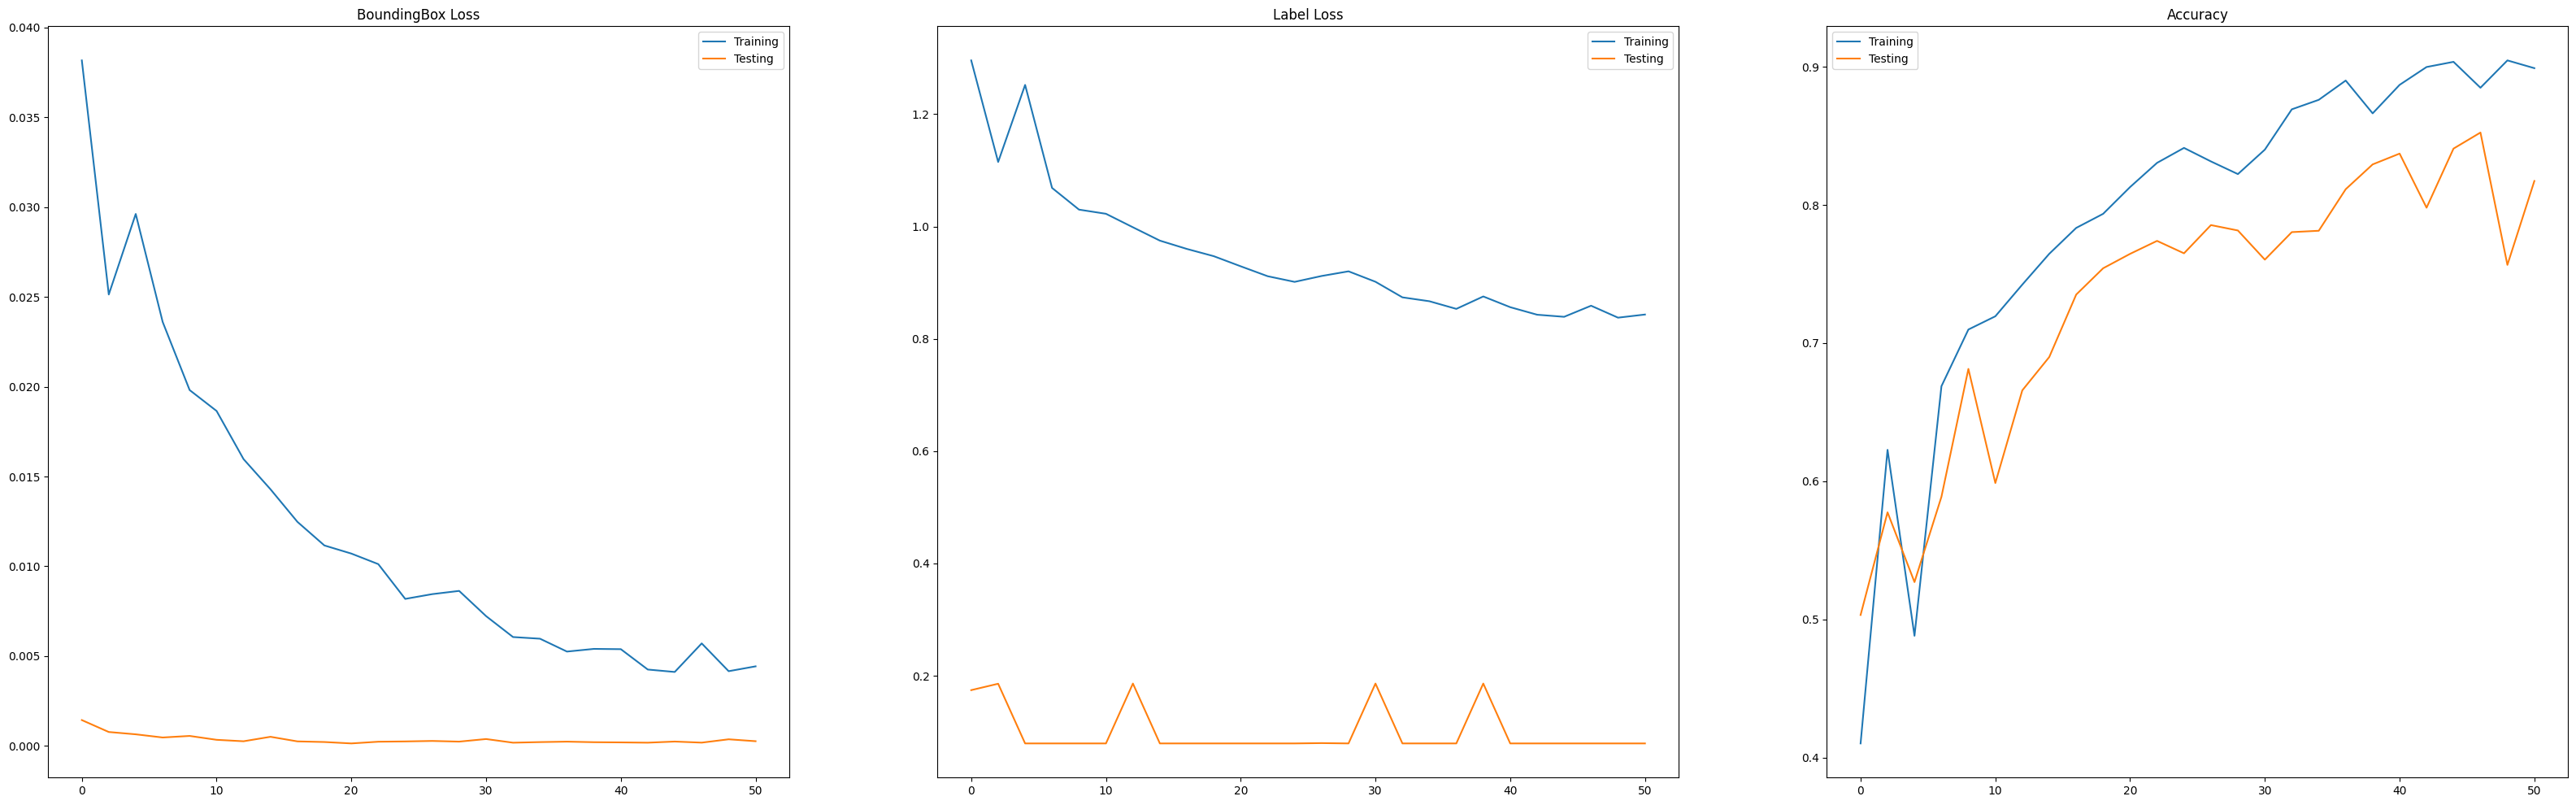

In [12]:
plt.subplots(1,3,figsize=(40,12))
plt.subplot(1,3,1)
sns.lineplot(x=epochs, y=[float(i.cpu())for i in training_loss_bbox], label="Training")
sns.lineplot(x=epochs, y=[float(i.cpu())for i in testing_loss_bbox], label="Testing")
plt.title("BoundingBox Loss")
plt.subplot(1,3,2)
sns.lineplot(x=epochs, y=[float(i.cpu())for i in training_loss_label], label="Training")
sns.lineplot(x=epochs, y=[float(i.cpu())for i in testing_loss_label], label="Testing")
plt.title("Label Loss")
plt.subplot(1,3,3)
sns.lineplot(x=epochs, y=training_acc, label="Training")
sns.lineplot(x=epochs, y=testing_acc, label="Testing")
plt.title("Accuracy")
plt.show()

# Model Testing

In [13]:
model_name = "Object_Localization_model_best_acc.pth"
model_save_path = model_path / model_name


mod_params = torch.load(model_save_path)
best_model = Network()
best_model.load_state_dict(mod_params)
best_model.to(device)

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 192, kernel_size=(5, 5), stride=(1, 1))
  (class_fc1): Linear(in_features=19200, out_features=240, bias=True)
  (class_fc2): Linear(in_features=240, out_features=120, bias=True)
  (class_out): Linear(in_features=120, out_features=4, bias=True)
  (box_fc1): Linear(in_features=19200, out_features=240, bias=True)
  (box_fc2): Linear(in_features=240, out_features=120, bias=True)
  (box_out): Linear(in_features=120, out_features=4, bias=True)
)

In [14]:
testing_sample = next(iter(testing_dloader))
images = testing_sample["image"].float().to(device)
labels = testing_sample["labels"][:,0].type(torch.LongTensor)
bbox = testing_sample["labels"][:, 1:].float()
with torch.inference_mode():
    [label_pred,b_box_pred]= best_model(images)

In [15]:
testing = {}
for i in range(64):
    testing[i] = {"image":images[i]*255 , 
                  "labels":labels[i], 
                  "pred_labels": [label_pred[i].argmax(dim=0), label_pred[i].max(dim=0)],
                  "bbox": bbox[i],
                    "bbox_pred": b_box_pred[i] }

### Visualizing a few predictions

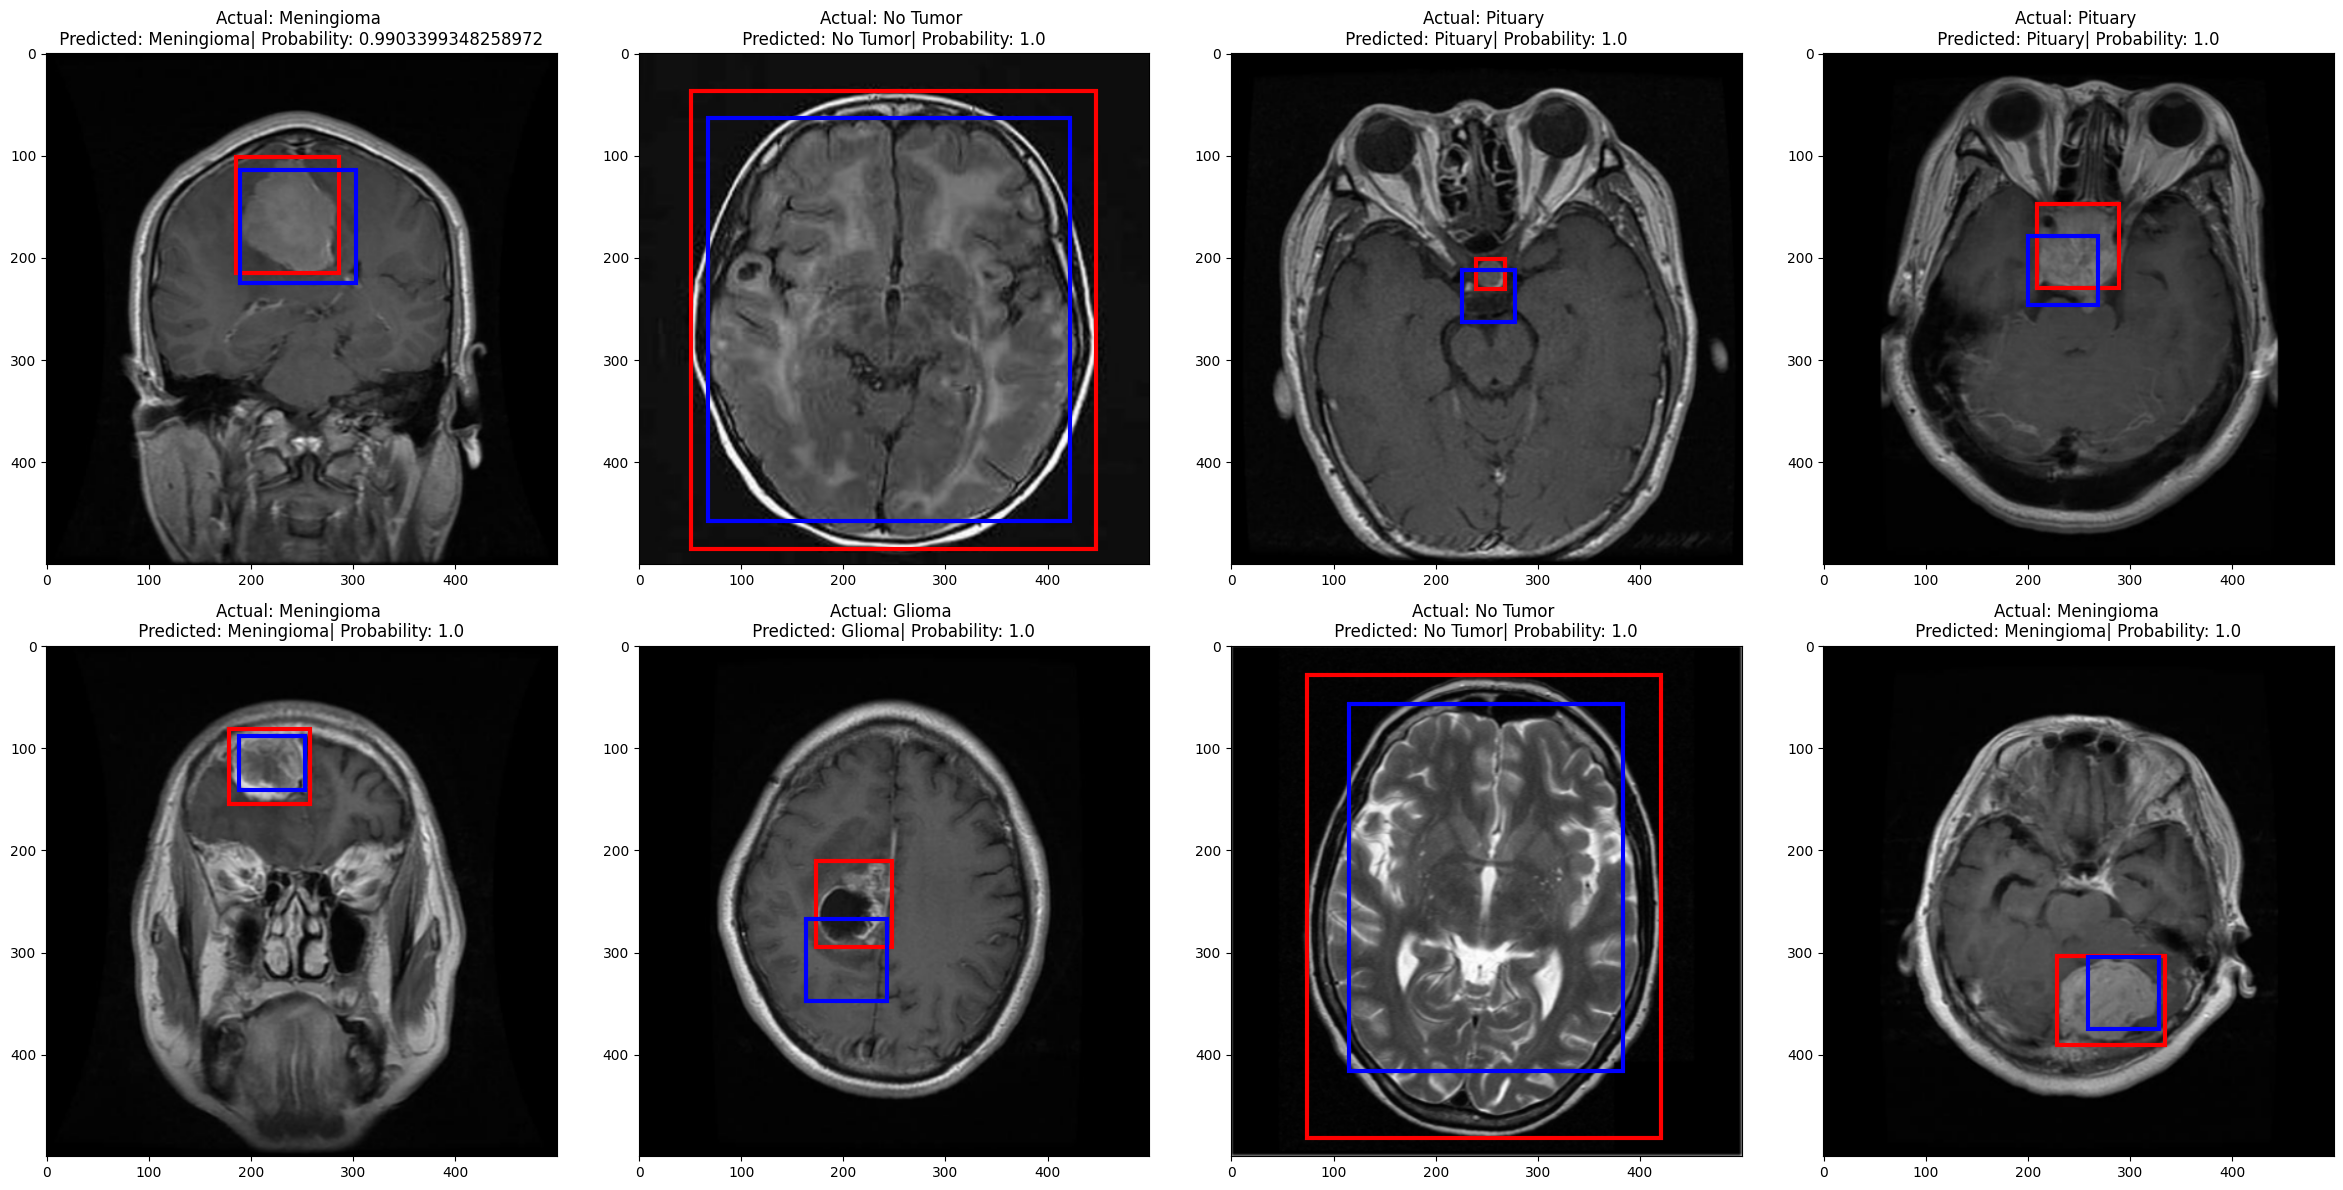

In [16]:
plt.subplots(2,4, figsize=(24,12))
k = 1
for i in range(24,32):
    ax = plt.subplot(2, 4, k)
    plt.tight_layout()
    image_reshaped = torch.reshape(testing[i]["image"].type(torch.uint16).cpu(),(500,500,3))
    plt.imshow(image_reshaped.detach().numpy())
    bounding_box_actual = testing[i]["bbox"].cpu().numpy()
    rect = patches.Rectangle(((bounding_box_actual[0]-(bounding_box_actual[2]/2))*500,(bounding_box_actual[1]-(bounding_box_actual[3]/2))*500), bounding_box_actual[2]*500, bounding_box_actual[3]*500, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    bounding_box_pred = testing[i]["bbox_pred"].cpu().numpy()
    rect = patches.Rectangle(((bounding_box_pred[0]-(bounding_box_pred[2]/2))*500,(bounding_box_pred[1]-(bounding_box_pred[3]/2))*500), bounding_box_pred[2]*500, bounding_box_pred[3]*500, linewidth=3, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(f"Actual: {tumor_dataset.label_to_class[float(testing[i]['labels'])]} \n Predicted: {tumor_dataset.label_to_class[float(testing[i]['pred_labels'][0])]}| Probability: {float(testing[i]['pred_labels'][1].values)} ")
    
    ax.axis()
    k += 1


Note: Red is actual bounding box and blue is the predicted one.

# Model Evaluation

Evaluation is mainly done on the testing set.

In [17]:
actual_label = []
predicted_label = []
actual_bounding_box = []
predicted_bounding_box = []
for data in testing_dloader:
    images,labels,b_boxes = data["image"].float().to(device), data["labels"][:,0].type(torch.LongTensor).to(device) , data["labels"][:,1:].float().to(device)
    with torch.no_grad():
        [label_pred,b_box_pred]= model(images)
    for i in range(len(labels)):
        actual_bounding_box.append(b_boxes[i].cpu().numpy())
        predicted_bounding_box.append(b_box_pred[i].cpu().numpy())
        actual_label.append(tumor_dataset.label_to_class[float(labels[i])])
        predicted_label.append(tumor_dataset.label_to_class[float(label_pred.argmax(dim=1)[i])]) 


<Axes: >

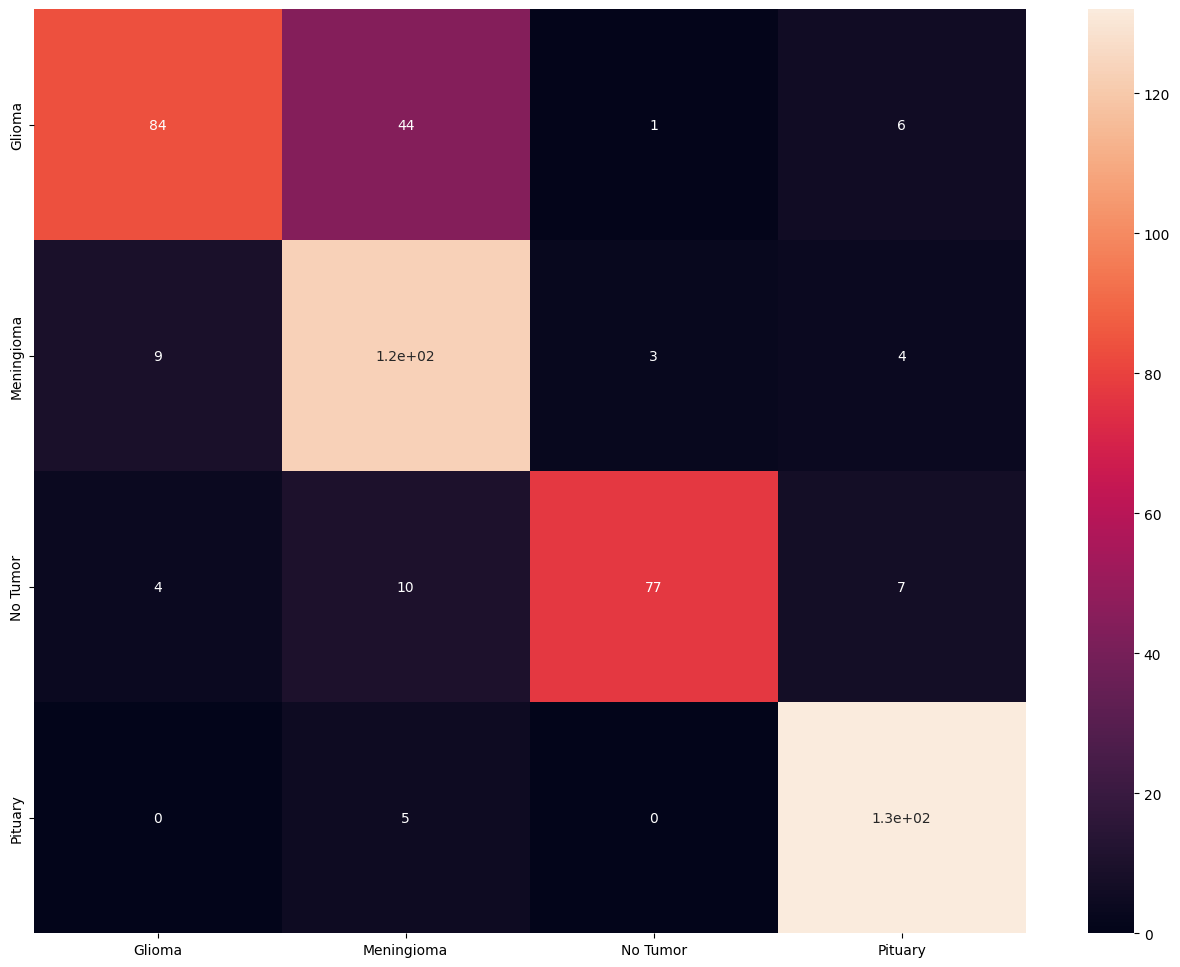

In [18]:
plt.figure(figsize=(16,12))
sns.heatmap(data=confusion_matrix(actual_label,predicted_label),
             annot=True, xticklabels=[tumor_dataset.label_to_class[float(i)] for i in range(4)], 
             yticklabels= [tumor_dataset.label_to_class[float(i)] for i in range(4)])

## Classification Report

In [19]:
print(classification_report(actual_label,predicted_label))

              precision    recall  f1-score   support

      Glioma       0.87      0.62      0.72       135
  Meningioma       0.68      0.88      0.77       139
    No Tumor       0.95      0.79      0.86        98
     Pituary       0.89      0.96      0.92       137

    accuracy                           0.82       509
   macro avg       0.84      0.81      0.82       509
weighted avg       0.84      0.82      0.82       509



## IOU Report

In [20]:
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
     
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
     
    area_of_intersection = i_height * i_width
     
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
     
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
     
    iou = area_of_intersection / area_of_union
     
    return iou



In [21]:
iou  = []
for i in range(len(actual_bounding_box)):
    iou.append(get_iou(actual_bounding_box[i], predicted_bounding_box[i]))

<Axes: >

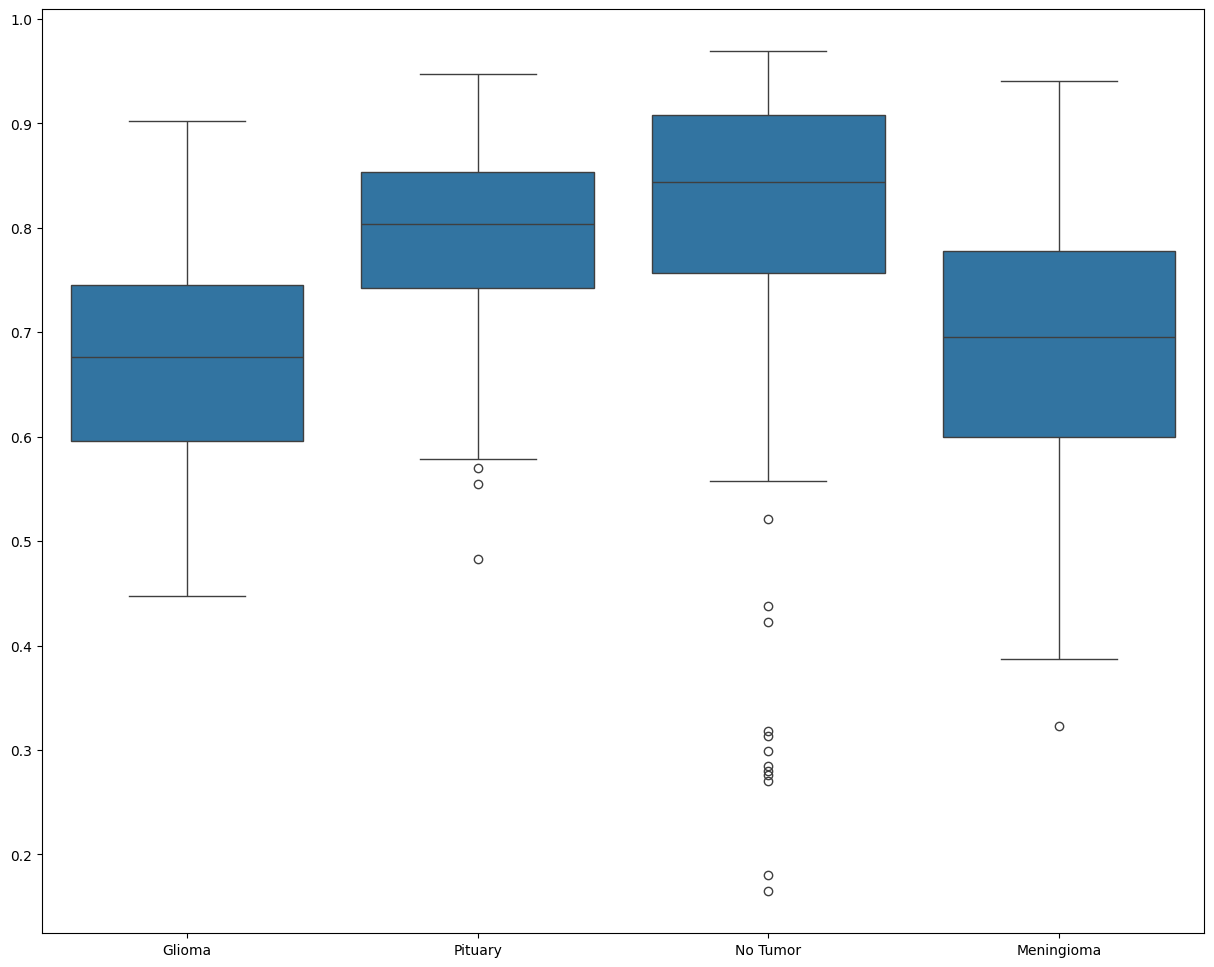

In [22]:
plt.figure(figsize=(15,12))
sns.boxplot(x=actual_label, y=iou)